In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize


%matplotlib notebook

Variables

In [3]:
outD = 7.77010  # primary diameter (m)
inD = 1.024  # inner M2 diameter (m)
m  = 8 

## GPI DM parameters
n = 48          # number sample points across the screen 
                # (Not the number of subapertures across the aperture which is less)
bign = n*m
nacross = 43.2    # number of subapertures across the aperture
    
## phase sample parameters
pscale = outD/(nacross)   #  pixel size (m) of samples in pupil plane

aperture

In [4]:
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= outD/2)
ap_inner = (ar <= inD/2)   
aperture = (ap_outer ^ ap_inner).astype(int)

In [35]:
aperture_nan = np.copy(aperture.astype(np.float))
aperture_nan[np.where(aperture==0)] = np.nan

open the file

In [34]:
#filename = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.27_0.40.14_poldm_phase.fits"
#filename = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.29_22.29.18_poldm_phase.fits"
filename = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160229/aored_When_2016.2.29_5.33.19_poldm_phase.fits"


hdulist = fits.open(filename,memmap=True)
phase = hdulist[0].data.astype('float')

# Get the phase dimensions
phdim = phase.shape 
phx   = phdim[1]
phy   = phdim[2]
timesteps = phdim[0]

print(phdim)

(21900, 48, 48)


In [125]:
def detilt(phase, aperture):
    """
    ;  detilt - remove tilt over an aperture
    ;
    ;  USAGE:
    ;    phdt = detilt(ph,ap)
    ;
    ;  INPUTS:
    ;    ph - phase cube   - 3D numpy array
    ;    ap - aperture - optional 2D numpy array
    ;
    ;  OUTPUTS:
    ;    phdt - phase with tilt removed
    ;    tx, ty - (optional) tip and tilt coefficients (units: phase/pixel)
    ;
    """
    
    nx = aperture.shape[1]  # number of columns
    ny = aperture.shape[0]  # number of rows
    
    a = np.arange(float(nx))
    b = np.arange(float(ny))
    
    xind = np.vstack((a,)*ny)
    yind = np.transpose(np.vstack((b,)*nx))
 
    xind = aperture*(xind - np.sum(xind*aperture)/aperture.sum())
    yind = aperture*(yind - np.sum(yind*aperture)/aperture.sum())   
    
    phdt = aperture*(phase - xind[None,:,:]*np.sum(phase*xind,axis = (1,2))[:,None,None]/np.sum(xind**2))
    phdt = aperture*(phase - yind[None,:,:]*np.sum(phase*yind,axis = (1,2))[:,None,None]/np.sum(yind**2))
    return phdt
    

In [7]:
def depiston(phase, aperture=np.zeros(1)):
    """
    ;  depiston - remove piston over an aperture
    ;
    ;  USAGE:
    ;    phdp = depiston(ph,ap)
    ;
    ;  INPUTS:
    ;    ph - 3D numpy array of phase [t,n,m]
    ;    ap - numpy array defining aperture[n,m] - optional
    ;
    ;  OUTPUTS:
    ;    phdp - phase with piston removed
    """
        
    if len(aperture) == 1: 
        aperture = np.ones(phase.shape)
          
    piston = np.sum(phase*aperture,axis =(1,2))/aperture.sum()
    phdp   = aperture*(phase - piston[:,None,None])

    return phdp

In [131]:
dp_phase = depiston(phase,aperture)
corr_phase = detilt(dp_phase,aperture)

In [127]:
np.nanmean(dt_phase[0]) # this is the piston that neads to be subtracted from the pupil

-4.9343245538895844e-17

<IPython.core.display.Javascript object>


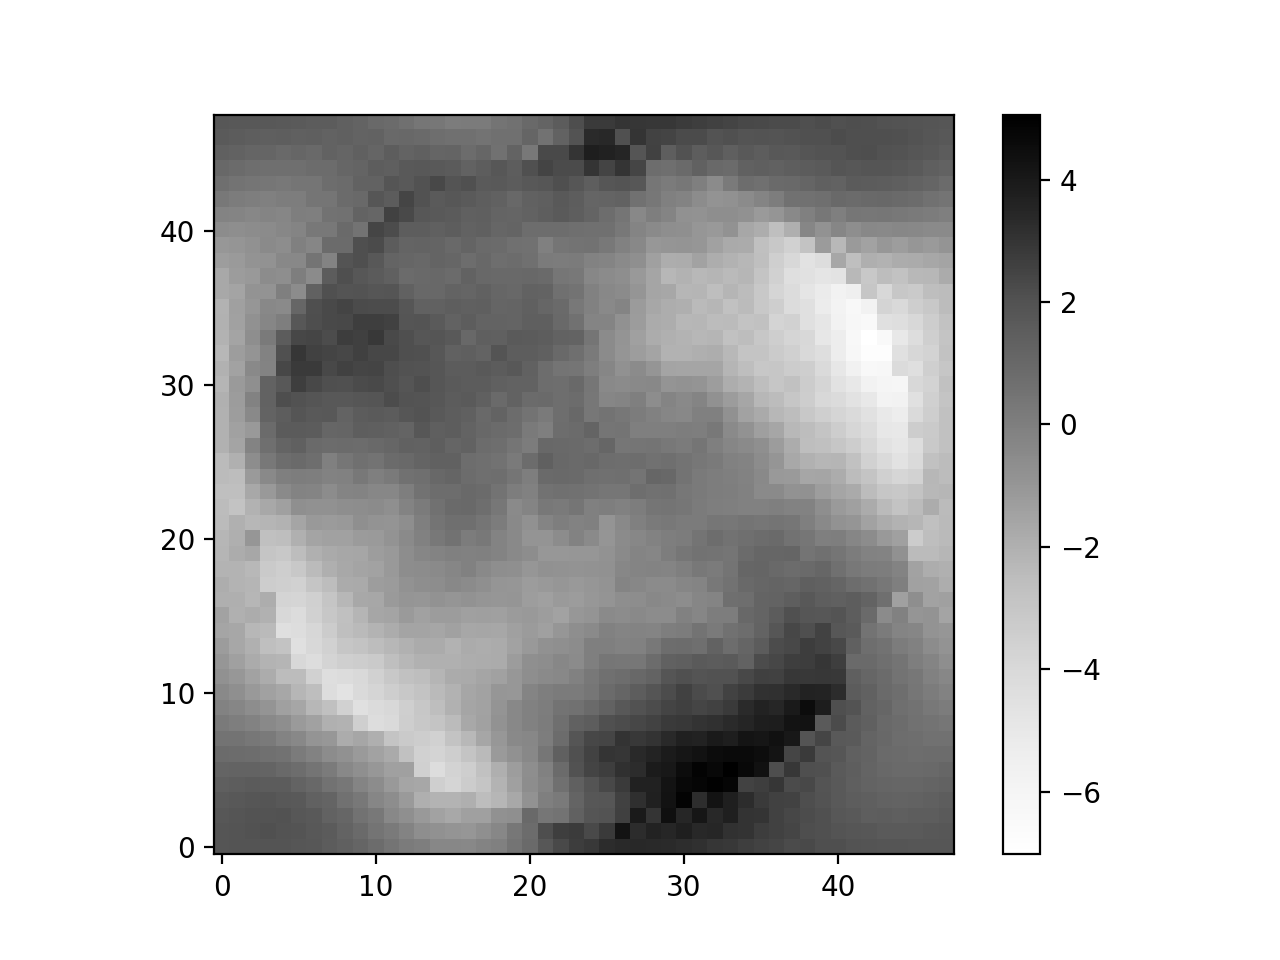

In [151]:
implot(phase[5000])

Compute 2d fourier transform

In [136]:
phFT = np.zeros((timesteps,phx,phy), dtype=complex)
for t in np.arange(timesteps):
    phFT[t,:,:] = fft.fftshift(fft.fft2(phase[t,:,:]*aperture))/aperture.sum()
print('Done with FT')

Done with FT


Make frequency grid

In [38]:
kx = fft.fftshift(fft.fftfreq(phx,pscale))
ky = fft.fftshift(fft.fftfreq(phy,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg))) 

Make psd

In [137]:
psd2D = np.zeros((timesteps, phx, phy),dtype=float)
for k in np.arange(phx):
    for l in np.arange(phy):
        psd2D[:,k,l] = np.abs(phFT[:,k,l])**2
        
avg_psd2D = np.mean(psd2D, axis=0)

In [ ]:
''' tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    t2bin = np.bincount(r.ravel(), image.ravel())
    binstd = np.sqrt(t2bin/nr - tbin**2)'''

 b = np.amax(r.ravel())+1 
    ## how many per bin (i.e., histogram)

    n,_ = np.histogram(r.ravel(),bins=b)
    sy,_ = np.histogram(r.ravel(),bins=b,weights=image.ravel())
    sy2,_ = np.histogram(r.ravel(),bins=b,weights=image.ravel()*image.ravel())
    mean = sy/n
    std = np.sqrt(sy2/n - mean*mean)
    

In [97]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    n = np.bincount(r.ravel())
    sy = np.bincount(r.ravel(), image.ravel())
    sy2 = np.bincount(r.ravel(), image.ravel()*image.ravel())
    mean = sy/n
    std = np.sqrt(sy2/n - mean*mean)
    
    return mean,std,n 



In [88]:
tx = fft.fftshift(fft.fftfreq(10,.1))
ty = fft.fftshift(fft.fftfreq(10,.1))
mg = np.meshgrid(tx,ty)
tr = np.sqrt(np.sum((m**2 for m in mg))) 

psd plot

In [10]:
def implot(image, display=True, **kwargs):
    """Plot an image with colorbar.
    
    image - The 2d image
    kwargs - settings for curstomizing plot"""

    ## Create matplotlib figure 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.imshow(image, cmap = plt.cm.Greys, origin='lower', interpolation='none')
    cbar = fig.colorbar(cax, orientation='vertical')

    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if 'cbar_label' in kwargs: cbar.set_label(kwargs['cbar_label'], 
                                              fontsize=18)
    if 'save_image' in kwargs: plt.savefig(kwargs['save_image'])

    if display: plt.show()

In [114]:
def PSDplot(psd, freq, w = '', display=True, **kwargs):
    """Plot the 1D psd"""
    
    ##  create matplotlib figure
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    def func(x, a, b):
        return a+(b*x) 
    
    if len(w) > 0:
        par,pcov = optimize.curve_fit(func,np.log10(freq[freq>0.]),np.log10(psd[freq>0.]),sigma = w, p0=(1, 3.5))
        intercept = par[0]
        slope = par[1]
    else:
        par,pcov = optimize.curve_fit(func,np.log10(freq[freq>0.]),np.log10(psd[freq>0.]), p0=(1, 3.5))
        intercept = par[0]
        slope = par[1]
    
    ## Plot original PSD and linear fit
    img = ax.loglog((freq),(psd),'b.',(freq[freq>0]), 10**(func(np.log10(freq[freq>0]),*par)), 'r')

    ax.legend(['PSD', 'slope = {1:.2f}, intercept={0:.2f}'.format(slope, intercept)],loc=3, fontsize=10)
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='grey', linestyle='-')
    ax.set_ylabel('Power Spectrum')
    ax.set_xlabel('Spatial Frequency')
    
    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=10)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=15)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=15)
    if display: plt.show()

1d psd

In [138]:
avg_psd1D, rstd, nbin =  radialProfile(avg_psd2D)


<IPython.core.display.Javascript object>


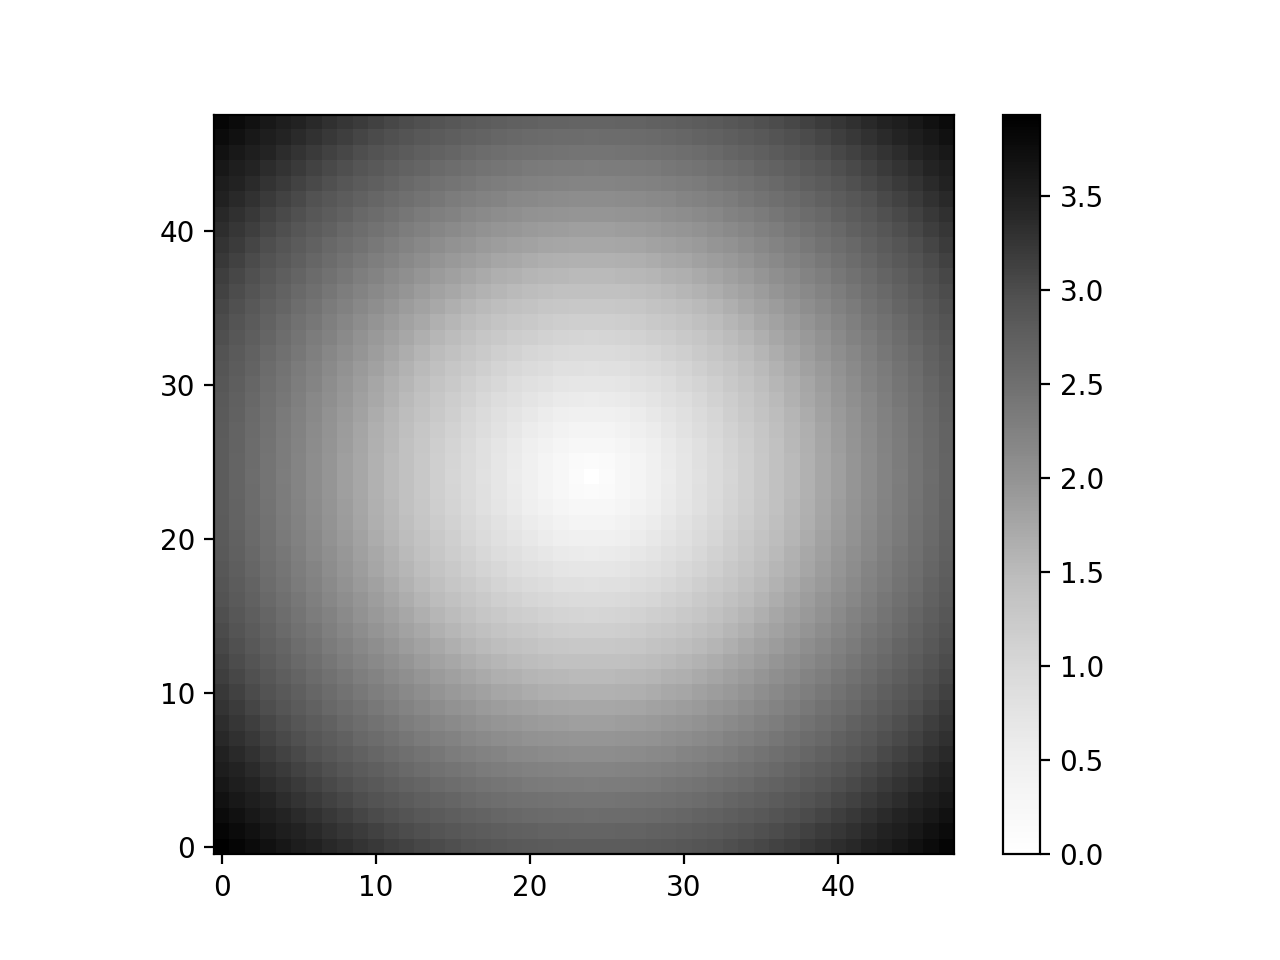

In [148]:
implot(kr)

<IPython.core.display.Javascript object>


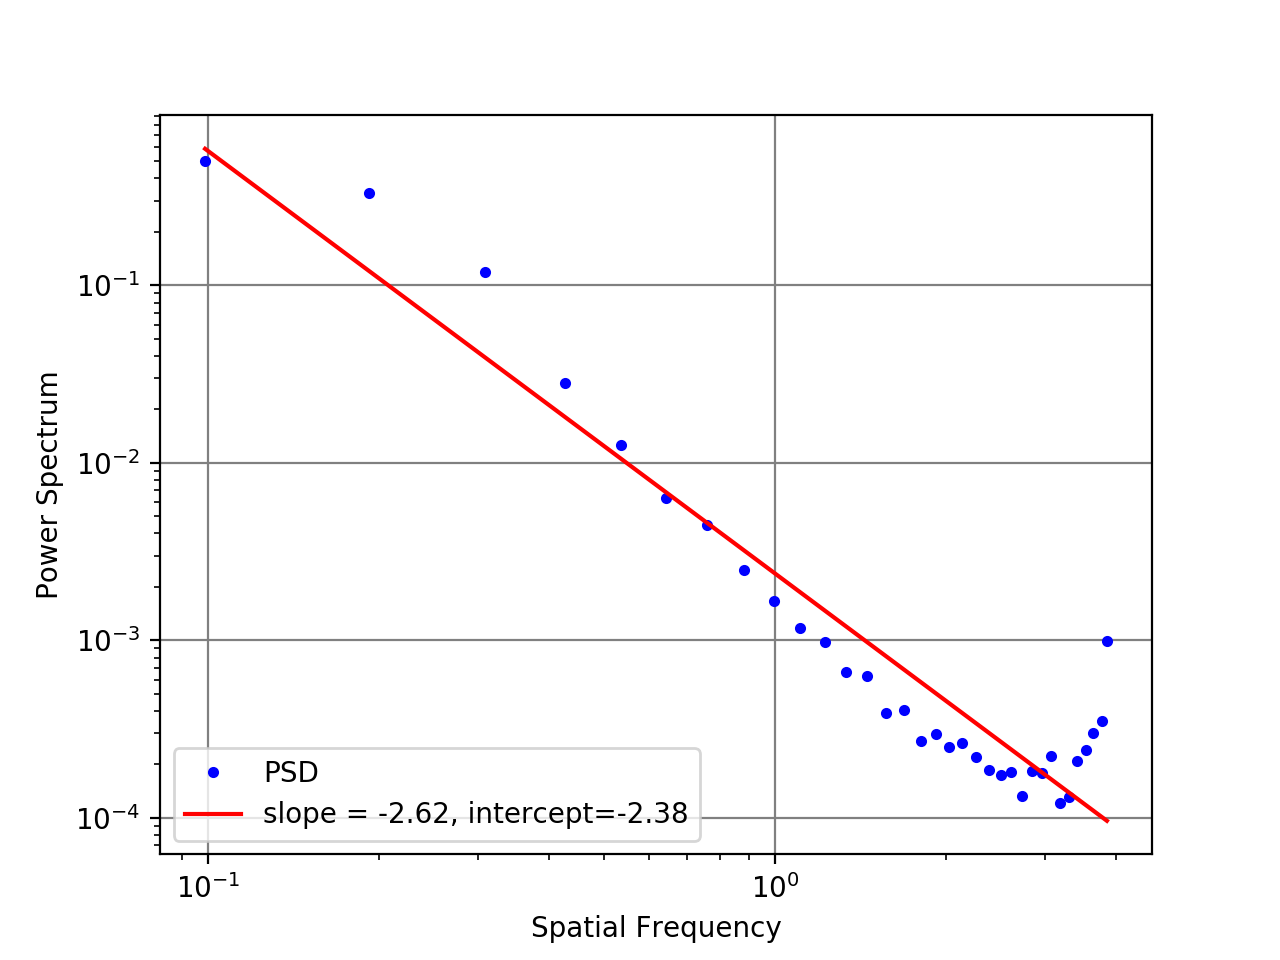

In [147]:
%matplotlib notebook


PSDplot(avg_psd1D,radialProfile(kr)[0])
#PSDplot(avg_psd2D.ravel(),kr.ravel())
